In [1]:
import math
import pandas as pd
import numpy as np

In [2]:
# Sentence Quality Score
def sentence_quality_score(sentence_id, sent_work_rel_dict, wqs, rqs):
    '''
    sentence_id
    work_sent_rel_dict
    rqs: dict of relation_id (string) -> relation quality (float)
    wqs: dict of worker_id (string) -> worker quality score
    '''
    
    sqs_numerator = 0.0
    sqs_denominator = 0.0
    worker_ids = list(sent_work_rel_dict[sentence_id].keys())

    for worker_i in range(len(worker_ids) - 1):
        for worker_j in range(worker_i + 1, len(worker_ids)):
            # print worker_ids[i] + " - " + worker_ids[j] + "\n"
            numerator = 0.0
            denominator_i = 0.0
            denominator_j = 0.0
            
            worker_i_vector = sent_work_rel_dict[sentence_id][worker_ids[worker_i]]
            worker_j_vector = sent_work_rel_dict[sentence_id][worker_ids[worker_j]]
            
            for relation in rqs:
                numerator += rqs[relation] * (worker_i_vector[relation] * worker_j_vector[relation])
                denominator_i += rqs[relation] * (worker_i_vector[relation] * worker_i_vector[relation])
                denominator_j += rqs[relation] * (worker_j_vector[relation] * worker_j_vector[relation])
            
            weighted_cosine = numerator / math.sqrt(denominator_i * denominator_j)
            sqs_numerator += weighted_cosine * wqs[worker_ids[worker_i]] * wqs[worker_ids[worker_j]]
            sqs_denominator += wqs[worker_ids[worker_i]] * wqs[worker_ids[worker_j]]
    
    return sqs_numerator / sqs_denominator


# Worker - Sentence Agreement
def worker_sentence_agreement(worker_id, sent_rel_dict, work_sent_rel_dict, sqs, rqs):
    '''
    worker_id
    sent_rel_dict
    work_sent_rel_dict
    sentence_vectors: data frame of sentence vectors
    sqs (sentence quality score): dict sentence_id -> sentence quality (float)
    rqs: dict of relation_id (string) -> relation quality (float)
    '''
    wsa_nominator = 0.0
    wsa_denominator = 0.0
    
    for sentence_id in work_sent_rel_dict[worker_id]:
        numerator = 0.0
        denominator_w = 0.0
        denominator_s = 0.0
        
        worker_vector = work_sent_rel_dict[worker_id][sentence_id]
        sentence_vector = sent_rel_dict[sentence_id]
        
        for relation in rqs:
            numerator += rqs[relation] * worker_vector[relation] * (sentence_vector[relation] - worker_vector[relation])
            denominator_w += rqs[relation] * (worker_vector[relation] * worker_vector[relation])
            denominator_s += rqs[relation] * ((sentence_vector[relation] - worker_vector[relation]) *
                                              (sentence_vector[relation] - worker_vector[relation]))
        weighted_cosine = numerator / math.sqrt(denominator_w * denominator_s)
        wsa_nominator += weighted_cosine * sqs[sentence_id]
        wsa_denominator += sqs[sentence_id]
    return wsa_nominator / wsa_denominator


# Worker - Worker Agreement
def worker_worker_agreement(worker_id, work_sent_rel_dict, sent_work_rel_dict, wqs, sqs, rqs):
    '''
    worker_id
    work_sent_rel_dict
    sent_work_rel_dict
    worker_vectors: data frame of worker vectors
    sqs (sentence quality score): dict sentence_id -> sentence quality (float)
    rqs: dict of relation_id (string) -> relation quality (float)
    '''
    
    wwa_nominator = 0.0
    wwa_denominator = 0.0
    
    wv = work_sent_rel_dict[worker_id]
    sentence_ids = list(work_sent_rel_dict[worker_id].keys())
    other_wv = worker_vectors.loc[worker_vectors["sentence_id"].isin(sentence_ids)]
    other_wv = other_wv.loc[other_wv["worker_id"] != worker_id]
    
    for sentence_id in work_sent_rel_dict[worker_id]:
        for other_worker_id in sent_work_rel_dict[sentence_id]:
            if worker_id != other_worker_id:
                numerator = 0.0
                denominator_w = 0.0
                denominator_ow = 0.0
                
                for relation in rqs:
                    numerator += rqs[relation] * (work_sent_rel_dict[worker_id][sentence_id][relation] *
                                                  sent_work_rel_dict[sentence_id][other_worker_id][relation])
                    denominator_w += rqs[relation] * (work_sent_rel_dict[worker_id][sentence_id][relation] *
                                                      work_sent_rel_dict[worker_id][sentence_id][relation])
                    denominator_ow += rqs[relation] * (sent_work_rel_dict[sentence_id][other_worker_id][relation] *
                                                       sent_work_rel_dict[sentence_id][other_worker_id][relation])
                weighted_cosine = numerator / math.sqrt(denominator_w * denominator_ow)
                wwa_nominator += weighted_cosine * wqs[other_worker_id] * sqs[sentence_id]
                wwa_denominator += wqs[other_worker_id] * sqs[sentence_id]
    return wwa_nominator / wwa_denominator


# Sentence - Relation Score
def sentence_relation_score(sentence_id, relation, sent_work_rel_dict, wqs):
    srs_nominator = 0.0
    srs_denominator = 0.0
    
    for worker_id in sent_work_rel_dict[sentence_id]:
        srs_nominator += sent_work_rel_dict[sentence_id][worker_id][relation] * wqs[worker_id]
        srs_denominator += wqs[worker_id]
    return srs_nominator / srs_denominator


# Relation Quality Score
def relation_quality_score(relations, work_sent_rel_dict, sqs, wqs):
    
    rqs_nominator = dict()
    rqs_denominator = dict()
    
    for relation in relations:
        rqs_nominator[relation] = 0.0
        rqs_denominator[relation] = 0.0
    
    worker_ids = work_sent_rel_dict.keys()
    for worker_i in worker_ids:
        for worker_j in worker_ids:
            if worker_i != worker_j and len(np.intersect1d(np.array(work_sent_rel_dict[worker_i].keys()),
                                                           np.array(work_sent_rel_dict[worker_j].keys()))) > 0:
                for relation in relations:
                    nominator = 0.0
                    denominator = 0.0

                    for sentence_id in work_sent_rel_dict[worker_i]:
                        if sentence_id in work_sent_rel_dict[worker_j]:
                            nominator += sqs[sentence_id] * (work_sent_rel_dict[worker_i][sentence_id][relation] *
                                                             work_sent_rel_dict[worker_j][sentence_id][relation])
                            denominator += sqs[sentence_id] * work_sent_rel_dict[worker_j][sentence_id][relation]
                    if denominator > 0:
                        rqs_nominator[relation] += wqs[worker_i] * wqs[worker_j] * nominator / denominator
                        rqs_denominator[relation] += wqs[worker_i] * wqs[worker_j]
    
    rqs = dict()
    for relation in relations:
        rqs[relation] = rqs_nominator[relation] / rqs_denominator[relation]
    return rqs

In [7]:
worker_vectors = pd.read_csv("work_vec.csv")
sentence_vectors = pd.read_csv("sent_vec.csv")
relations = pd.read_csv("relations.csv")

#initialize quality vectors
wqs = dict((worker_id, 1) for worker_id in worker_vectors["worker_id"])
sqs = dict((sentence_id, 1) for sentence_id in sentence_vectors["sentence_id"])
rqs = relations.set_index('relation').to_dict()['rqs']

sent_work_rel_dict = dict()
work_sent_rel_dict = dict()
sent_rel_dict = dict()

for idx in range(len(worker_vectors["worker_id"])):
    worker_id = worker_vectors["worker_id"][idx]
    sentence_id = worker_vectors["sentence_id"][idx]
    if worker_id not in work_sent_rel_dict:
        work_sent_rel_dict[worker_id] = dict()
    if sentence_id not in sent_work_rel_dict:
        sent_work_rel_dict[sentence_id] = dict()
    
    if sentence_id not in work_sent_rel_dict[worker_id]:
        work_sent_rel_dict[worker_id][sentence_id] = dict()
    if worker_id not in sent_work_rel_dict[sentence_id]:
        sent_work_rel_dict[sentence_id][worker_id] = dict()
    
    for relation in rqs:
        work_sent_rel_dict[worker_id][sentence_id][relation] = worker_vectors[relation][idx]
        sent_work_rel_dict[sentence_id][worker_id][relation] = worker_vectors[relation][idx]

for idx in range(len(sentence_vectors["sentence_id"])):
    sent_rel_dict[sentence_vectors["sentence_id"][idx]] = dict()
    for relation in rqs:
        sent_rel_dict[sentence_vectors["sentence_id"][idx]][relation] = sentence_vectors[relation][idx]

# wsa = dict()
# for worker_id in work_sent_rel_dict:
#     wsa[worker_id] = worker_sentence_agreement(worker_id, sent_rel_dict, work_sent_rel_dict, sqs, rqs)
# print wsa

# wwa = dict()
# for worker_id in work_sent_rel_dict:
#     wwa[worker_id] = worker_worker_agreement(worker_id, work_sent_rel_dict, sent_work_rel_dict, wqs, sqs, rqs)
# print wwa

# for sentence_id in sent_work_rel_dict::
#     sqs[sentence_id] = sentence_quality_score(sentence_id, sent_work_rel_dict, wqs, rqs)
# print sqs

# srs = dict()
# for sentence_id in sent_work_rel_dict:
#     srs[sentence_id] = dict()
#     for relation in rqs:
#         srs[sentence_id][relation] = sentence_relation_score(sentence_id, relation, sent_work_rel_dict, wqs)
# print srs

In [8]:
wqs_list = list()
sqs_list = list()
rqs_list = list()

wqs_list.append(wqs.copy())
sqs_list.append(sqs.copy())
rqs_list.append(rqs.copy())

max_delta = 0.001
iterations = 0

while max_delta >= 0.001:
    sqs_new = dict()
    wqs_new = dict()
    
    avg_sqs_delta = 0.0
    avg_wqs_delta = 0.0
    avg_rqs_delta = 0.0
    max_delta = 0.0
    
    for sentence_id in sent_work_rel_dict:
        sqs_new[sentence_id] = sentence_quality_score(sentence_id, sent_work_rel_dict,
                                                      wqs_list[len(wqs_list) - 1],
                                                      rqs_list[len(rqs_list) - 1])
        max_delta = max(max_delta, abs(sqs_new[sentence_id] - sqs_list[len(sqs_list) - 1][sentence_id]))
        avg_sqs_delta += abs(sqs_new[sentence_id] - sqs_list[len(sqs_list) - 1][sentence_id])
        if abs(sqs_new[sentence_id] - sqs_list[len(sqs_list) - 1][sentence_id]) > 0.999 and iterations > 5:
            print sentence_id
    avg_sqs_delta /= len(sqs_new.keys()) * 1.0
    
    for worker_id in work_sent_rel_dict:
        wwa = worker_worker_agreement(worker_id, work_sent_rel_dict, sent_work_rel_dict,
                                      wqs_list[len(wqs_list) - 1],
                                      sqs_list[len(sqs_list) - 1],
                                      rqs_list[len(rqs_list) - 1])
        wsa = worker_sentence_agreement(worker_id, sent_rel_dict, work_sent_rel_dict,
                                        sqs_list[len(sqs_list) - 1],
                                        rqs_list[len(rqs_list) - 1])
        wqs_new[worker_id] = wwa * wsa
        max_delta = max(max_delta, abs(wqs_new[worker_id] - wqs_list[len(wqs_list) - 1][worker_id]))
        avg_wqs_delta += abs(wqs_new[worker_id] - wqs_list[len(wqs_list) - 1][worker_id])
        if abs(wqs_new[worker_id] - wqs_list[len(wqs_list) - 1][worker_id]) > 0.999 and iterations > 5:
            print worker_id
    avg_wqs_delta /= len(wqs_new.keys()) * 1.0
    
    rqs_new = relation_quality_score(rqs.keys(), work_sent_rel_dict,
                                     sqs_list[len(sqs_list) - 1],
                                     wqs_list[len(wqs_list) - 1])
    for relation in rqs_new:
        max_delta = max(max_delta, abs(rqs_new[relation] - rqs_list[len(rqs_list) - 1][relation]))
        avg_rqs_delta += abs(rqs_new[relation] - rqs_list[len(rqs_list) - 1][relation])
    avg_rqs_delta /= len(rqs_new.keys()) * 1.0
    
    iterations += 1
    wqs_list.append(wqs_new.copy())
    sqs_list.append(sqs_new.copy())
    rqs_list.append(rqs_new.copy())
    print str(iterations) + " iterations; max d= " + str(max_delta) + " ; wqs d= " + str(avg_wqs_delta) + "; sqs d= " + str(avg_sqs_delta) + "; rqs d= " + str(avg_rqs_delta)

1 iterations; max d= 1.0 ; wqs d= 0.553886434879; sqs d= 0.396470203476; rqs d= 0.418607310549
2 iterations; max d= 0.286057109253 ; wqs d= 0.10290864499; sqs d= 0.0510098764171; rqs d= 0.073169657298
3 iterations; max d= 0.05604703452 ; wqs d= 0.00761370176294; sqs d= 0.0055877544102; rqs d= 0.00551735858764
4 iterations; max d= 0.0236401865824 ; wqs d= 0.00241960090165; sqs d= 0.00219319402518; rqs d= 0.0024072242453
5 iterations; max d= 0.00730883271752 ; wqs d= 0.000546140790202; sqs d= 0.000391843565961; rqs d= 0.000328939867273
6 iterations; max d= 0.00266893935759 ; wqs d= 0.000171733995101; sqs d= 0.000150031834724; rqs d= 0.000159970062916
7 iterations; max d= 0.000917045197753 ; wqs d= 4.96209909582e-05; sqs d= 3.38228635128e-05; rqs d= 2.77450297911e-05


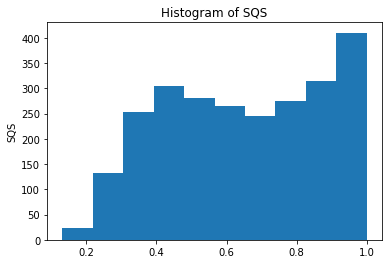

In [9]:
%matplotlib inline  

import matplotlib.pyplot as plt

sqs = sqs_list[len(sqs_list) - 1]
wqs = wqs_list[len(wqs_list) - 1]

plt.hist(sqs.values())
plt.ylabel('SQS')
plt.title('Histogram of SQS')

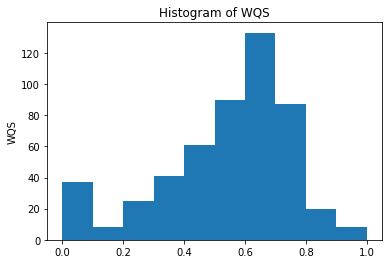

In [10]:
plt.hist(wqs.values())
plt.ylabel('WQS')
plt.title('Histogram of WQS')

In [7]:
work_data = pd.DataFrame(wqs.items(), columns=['worker_id', 'wqs'])
sent_data = pd.DataFrame(sqs.items(), columns=['sentence_id', 'sqs'])

work_data.to_csv("wqs.csv")
sent_data.to_csv("sqs.csv")

In [8]:
def variance_relation_quality_score(relation, srs, sqs):
    rqs_nominator = 0.0
    rqs_denominator = 0.0
    for sentence_id in srs:
        rqs_nominator += sqs[sentence_id] * ((srs[sentence_id][relation] - 0.25) * 
                                             (srs[sentence_id][relation] - 0.25) / 0.25)
        rqs_denominator += sqs[sentence_id]
    return rqs_nominator / rqs_denominator

srs = dict()
for sentence_id in sent_work_rel_dict:
    srs[sentence_id] = dict()
    for relation in rqs:
        srs[sentence_id][relation] = sentence_relation_score(sentence_id, relation, sent_work_rel_dict, wqs)
for relation in rqs:
    rqs[relation] = variance_relation_quality_score(relation, srs, sqs)

print rqs

{'none': 0.38495170536102469, 'per:top_member_employee_of_org': 0.52789396854091464, 'per:founded_org': 0.25386827586178268, 'per:children': 0.2848788383253596, 'org:alternate_names': 0.31802619537085564, 'per:age': 0.27226731965666134, 'per:charges': 0.30077315142073852, 'per:schools_attended': 0.2605005449614336, 'per:employee_or_member_of': 0.62339980817777552, 'per:spouse': 0.28817706590382158, 'org:subsidiaries': 0.2471166207884388, 'per:places_of_residence': 0.21349819421490918, 'per:cause_of_death': 0.26513169349013016, 'per:place_of_birth': 0.52134538041334688, 'per:title': 0.26689076447224008, 'org:place_of_headquarters': 0.23986899737119952, 'per:place_of_death': 0.25152760710880412}


In [31]:
def relation_quality_score(relations, work_sent_rel_dict, sqs, wqs):
    
    rqs_nominator = dict()
    rqs_denominator = dict()
    
    for relation in relations:
        rqs_nominator[relation] = 0.0
        rqs_denominator[relation] = 0.0
    
    worker_ids = work_sent_rel_dict.keys()
    for worker_i in worker_ids:
        for worker_j in worker_ids:
            if worker_i != worker_j and len(np.intersect1d(np.array(work_sent_rel_dict[worker_i].keys()),
                                                           np.array(work_sent_rel_dict[worker_j].keys()))) > 0:
                for relation in relations:
                    nominator = 0.0
                    denominator = 0.0

                    for sentence_id in work_sent_rel_dict[worker_i]:
                        if sentence_id in work_sent_rel_dict[worker_j]:
                            nominator += sqs[sentence_id] * (work_sent_rel_dict[worker_i][sentence_id][relation] *
                                                             work_sent_rel_dict[worker_j][sentence_id][relation])
                            denominator += sqs[sentence_id] * work_sent_rel_dict[worker_j][sentence_id][relation]
                    if denominator > 0:
                        rqs_nominator[relation] += wqs[worker_i] * wqs[worker_j] * nominator / denominator
                        rqs_denominator[relation] += wqs[worker_i] * wqs[worker_j]
    
    rqs = dict()
    for relation in relations:
        rqs[relation] = rqs_nominator[relation] / rqs_denominator[relation]
    return rqs

rqs_new = relation_quality_score(rqs.keys(), work_sent_rel_dict, sqs, wqs)
print rqs_new

{'none': 0.6196061516405649, 'per:top_member_employee_of_org': 0.7215411525029158, 'per:founded_org': 0.5025169613618161, 'per:title': 0.6258078182534962, 'per:schools_attended': 0.6386898158972372, 'org:alternate_names': 0.7814830960549048, 'per:age': 0.8667763992773511, 'per:charges': 0.7723701985309992, 'per:employee_or_member_of': 0.7744044499515211, 'per:spouse': 0.8034196806545811, 'org:subsidiaries': 0.4174921576303546, 'per:cause_of_death': 0.6605378361443947, 'per:place_of_birth': 0.8129952104439542, 'per:children': 0.8296356455789913, 'per:places_of_residence': 0.41696924559616866, 'org:place_of_headquarters': 0.3689433600030955, 'per:place_of_death': 0.4625475908346824}


In [11]:
print rqs_list[len(rqs_list) - 1]

{'per:top_member_employee_of_org': 0.7227125486496527, 'org:alternate_names': 0.7814947817623684, 'per:schools_attended': 0.637767468899016, 'per:age': 0.8664689406206121, 'per:charges': 0.772190396777661, 'org:subsidiaries': 0.41665148474336067, 'per:cause_of_death': 0.6607613423585488, 'org:place_of_headquarters': 0.36795341345151134, 'per:title': 0.6249635997120274, 'per:place_of_death': 0.4617569361484294, 'none': 0.6191409001865292, 'per:founded_org': 0.5009398062409746, 'per:places_of_residence': 0.4154409442877624, 'per:employee_or_member_of': 0.7756921323338388, 'per:spouse': 0.8037101902621104, 'per:place_of_birth': 0.8142157221195012, 'per:children': 0.8294828501760665}
